Dependencies

In [1]:
import numpy as np
import pandas as pd
import optuna
import copy
import random
import math
import heuristics
import importlib
from tqdm import tqdm
from matplotlib import pyplot as plt

d:\ycondabase\envs\aivenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(heuristics)

<module 'heuristics' from 'd:\\esi-4\\SEMESTRE_2\\TOIA\\TPs\\TP5-hyperheuristique-Yartix\\heuristics.py'>

Class to hold a taillard instance

In [3]:
class Inst:
    def __init__(self, jobs: int, machines: int, seed: int, ub: int, lb: int, matrix: list[list[int]]):
        """
        Represents an instance of the scheduling problem.
        
        Args:
            jobs (int): Number of jobs.
            machines (int): Number of machines.
            seed (int): Seed for random number generation.
            ub (int): Upper bound.
            lb (int): Lower bound.
            matrix (list[list[int]]): Matrix representing job durations on machines.
        """
        self.jobs = jobs
        self.machines = machines
        self.seed = seed
        self.ub = ub
        self.lb = lb
        self.matrix = matrix

function to load the instances of a taillard configuration

In [4]:
# loading the instances from the benchmark file
def load_tai(nb_jobs, nb_machines):
    with open(f"content/tai{nb_jobs}_{nb_machines}.txt", "r") as f:
        lines = f.readlines()

    instances: list[Inst] = []
    i = 0
    while i < len(lines):
        params = [int(e) for e in lines[i+1].split()]
        jobs = params[0]
        machines = params[1]
        seed = params[2]
        ub = params[3]
        lb = params[4]

        matrix = [[int(e) for e in line.strip().split()] for line in lines[i+3:i+3+machines]]
        instances.append(Inst(jobs, machines, seed, ub, lb, matrix))
        i+=3+machines
    
    return instances

In [5]:
class SAGA:
    def __init__(self,
                 tai_inst:Inst,
                 init_type=['cds', 'palmer', 'neh', 'heuristics', 'heuristics_random', 'full_random'],
                 selection_type=['roulette', 'rank', 'elitist', 'tournament', 'random'],
                 crossover_type=['uniform', 'one_point', 'two_points', 'k_points'],
                 replacement_type=['best_all', 'parents_replaced_by_offspring', 'worst_population_replaced_by_offspring', 'best_between_parents_and_offspring', 'roulette', 'rank', 'elitist', 'tournament', 'random'],
                 population_size_mms=(20,50,1), #min_max_step
                 pool_size_mms=(10,20, 1),
                 crossover_rate_mms=(0.1, 0.9, 0.1),
                 mutation_rate_mms=(0.1, 0.9, 0.1),
                 num_iterations_mms=(200, 1000, 100),
                 max_stagnation_mms=(50, 200, 50),
                 k_points_mms=(1,3,1),
                 variety_degree=1,
                 num_hyper_params_neigh_window=1, #numeric hyper-parameters neighboring window size
                 use_neh = True
                ):
        self.tai_inst = tai_inst
        self.jobs_list = self.get_instance(tai_inst)
        self.nb_jobs = len(self.jobs_list)
        self.nb_machines = len(self.jobs_list[0])
        self.seq_star = None
        self.make_span_star = None
        self.hyper_params = {
            'init_type': init_type,
            'selection_type': selection_type,
            'crossover_type': crossover_type,
            'replacement_type': replacement_type,
            'population_size': [i for i in range(population_size_mms[0], population_size_mms[1]+1, population_size_mms[2])],
            'pool_size': [i for i in range(pool_size_mms[0], pool_size_mms[1]+1, pool_size_mms[2])],
            'crossover_rate': [crossover_rate_mms[0]+crossover_rate_mms[2]*i for i in range(int((crossover_rate_mms[1]-crossover_rate_mms[0])/crossover_rate_mms[2])+1)],
            'mutation_rate': [mutation_rate_mms[0]+mutation_rate_mms[2]*i for i in range(int((mutation_rate_mms[1]-mutation_rate_mms[0])/mutation_rate_mms[2])+1)],
            'num_iterations': [i for i in range(num_iterations_mms[0], num_iterations_mms[1]+1, num_iterations_mms[2])],
            'max_stagnation': [i for i in range(max_stagnation_mms[0],max_stagnation_mms[1]+1,max_stagnation_mms[2])],
            'k_points': [i for i in range(k_points_mms[0],k_points_mms[1]+1,k_points_mms[2])]
        }
        self.cat_hyper_params = ['init_type', 'selection_type', 'crossover_type', 'replacement_type']
        self.num_hyper_params = ['population_size', 'pool_size', 'crossover_rate', 'mutation_rate', 'num_iterations', 'max_stagnation', 'k_points']
        self.variety_degree = variety_degree
        self.num_hyper_params_neigh_window = num_hyper_params_neigh_window
        print('INITIALIZING NEH')
        if use_neh:
            self.neh_res = heuristics.NEH(self.tai_inst)()
        else:
            self.neh_res = random.sample(range(self.nb_jobs), self.nb_jobs)
        print('INITIALIZING PALMER')
        self.palmer_res = heuristics.Palmer(self.jobs_list).optim()
        print('INITIALIZING CDS')
        self.cds_res = heuristics.cds_heuristic(np.array(self.jobs_list))



    # genetic algorithm for flowshop utilities
    def get_instance(self, tai_inst: Inst):
        # Extract the jobs list from the given instance
        
        jobs_list = []
        for i in range(len(tai_inst.matrix[0])):
            jobs_list.append([])
            for j in range(len(tai_inst.matrix)):
                jobs_list[-1].append(tai_inst.matrix[j][i])
        return jobs_list

    def cumulate(self, job: list, previous_cumul=None):
        # Calculate the cumulative completion times for a job
            
        res = [0] * len(job)
        if previous_cumul == None:
            res[0] = job[0]
            for i in range(1, len(job)):
                res[i] = res[i - 1] + job[i]
        else:
            res[0] = previous_cumul[0] + job[0]
            for i in range(1, len(job)):
                res[i] = max(res[i - 1], previous_cumul[i]) + job[i]
        return res

    def cumulate_seq(self, seq: list):
        # Calculates the cumulative time for a sequence of jobs on machines.

        cumulated = None
        for i in seq:
            cumulated = self.cumulate(self.jobs_list[i], cumulated)
        return cumulated

    def evaluate_makespan(self, schedule):
        # Evaluates the makespan (completion time) of a given schedule.

        cumulative = self.cumulate_seq(schedule)
        return cumulative[-1]
 
    def initialize_population(self, init_type, population_size):
        """
        Initializes the population of individuals.
        
        Args:
            init_type (str): Type of initialization method.
            population_size (int): Size of the population.
            
        Returns:
            list: Initialized population of individuals.
        """
        
        def perturb_sequence(sequence):
            """
            Perturbs a sequence by swapping two random jobs.
            
            Args:
                sequence (list): Sequence of jobs.
                
            Returns:
                list: Perturbed sequence.
            """
            perturbed_seq = sequence[:]
            for _ in range(2):
                i, j = random.sample(range(len(perturbed_seq)), 2)
                perturbed_seq[i], perturbed_seq[j] = perturbed_seq[j], perturbed_seq[i]
            return perturbed_seq

        population = []
        
        if init_type == "cds":
            cds_seq, _ = self.cds_res#heuristics.cds_heuristic(np.array(self.jobs_list))
            population.append(cds_seq)
            for _ in range(population_size - 1):
                perturbed_seq = perturb_sequence(cds_seq)
                population.append(perturbed_seq)

        elif init_type == "palmer":
            palmer_seq, _ = self.palmer_res#heuristics.Palmer(self.jobs_list).optim()
            population.append(palmer_seq)
            for _ in range(population_size - 1):
                perturbed_seq = perturb_sequence(palmer_seq)
                population.append(perturbed_seq)

        elif init_type == "neh":
            _, neh_seq = self.neh_res#heuristics.NEH(self.tai_inst)()
            population.append(neh_seq)
            for _ in range(population_size - 1):
                perturbed_seq = perturb_sequence(neh_seq)
                population.append(perturbed_seq)

        elif init_type == "heuristics":
            cds_size = population_size // 3
            palmer_size = population_size // 3
            neh_size = population_size - cds_size - palmer_size
            
            for _ in range(cds_size):
                cds_seq, _ = self.cds_res#heuristics.cds_heuristic(np.array(self.jobs_list))
                population.append(perturb_sequence(cds_seq))
            
            for _ in range(palmer_size):
                palmer_seq, _ = self.palmer_res#heuristics.Palmer(self.jobs_list).optim()
                population.append(perturb_sequence(palmer_seq))
            
            for _ in range(neh_size):
                _, neh_seq = self.neh_res#heuristics.NEH(self.tai_inst)()
                population.append(perturb_sequence(neh_seq))

        elif init_type == "heuristics_random":

            cds_seq, _ = self.cds_res#heuristics.cds_heuristic(np.array(self.jobs_list))
            population.append(perturb_sequence(cds_seq))

            palmer_seq, _ = self.palmer_res#heuristics.Palmer(self.jobs_list).optim()
            population.append(perturb_sequence(palmer_seq))

            _, neh_seq = self.neh_res#heuristics.NEH(self.tai_inst)()
            population.append(perturb_sequence(neh_seq))

            for _ in range(population_size - 3):
                random_seq = random.sample(range(self.nb_jobs), self.nb_jobs)
                population.append(random_seq)

        elif init_type == "full_random":

            for _ in range(population_size):
                random_seq = random.sample(range(self.nb_jobs), self.nb_jobs)
                population.append(random_seq)

        else:
            raise ValueError("Invalid initialization type")

        return population
  
    def select_parents(self, population):
        """
        Selects parents from the population using tournament selection.
        
        Args:
            population (list): Population of individuals.
            
        Returns:
            tuple: Pair of selected parents.
        """
        tournament = random.sample(population, 3)
        tournament.sort(key=lambda x: self.evaluate_makespan(x))
        return tournament[0], tournament[1]
  
    def crossover(self, crossover_type, parent1, parent2, crossover_rate, k_points=None):
        """
        Performs crossover between two parents to produce offspring.
        
        Args:
            crossover_type (str): Type of crossover operation.
            parent1 (list): First parent.
            parent2 (list): Second parent.
            crossover_rate (float): Rate of crossover.
            k (int, optional): Parameter for k-point crossover. Defaults to None.
            
        Returns:
            tuple: Pair of offspring.
        """

        def ensure_each_job_once(offspring):
            """
            Ensures each job appears exactly once in the offspring.
            
            Args:
                offspring (list): Offspring sequence.
            """
            # Ensure offspring contains each job exactly once
            job_count = {job: 0 for job in range(self.nb_jobs)}
            for job in offspring:
                job_count[job] += 1
            for i, job in enumerate(offspring):
                if job_count[job] > 1:
                    for swap_job, count in job_count.items():
                        if count == 0:
                            offspring[i] = swap_job
                            job_count[swap_job] += 1
                            job_count[job] -= 1
                            break

        if random.random() < crossover_rate:
            
            if crossover_type == 'uniform':
                k = None
                mask = [random.choice([0, 1]) for _ in range(len(parent1))]
                offspring1 = [gene1 if bit else gene2 for gene1, gene2, bit in zip(parent1, parent2, mask)]
                offspring2 = [gene1 if bit else gene2 for gene1, gene2, bit in zip(parent2, parent1, mask)]

            else:
                if k_points is None or k_points < 1:
                    raise ValueError("k must be >= 1 for one_point, two_points, and k_points crossovers")
                
                if k_points is not None and k_points >= self.nb_jobs:
                    raise ValueError("k in crossover must be less than the number of jobs")

                if ((crossover_type == 'one_point') or (k_points == 1)):
                    k = 1
                    points = [random.randint(1, len(parent1) - 1)]

                elif ((crossover_type == 'two_points') or (k_points == 2)):
                    k = 2
                    points = sorted(random.sample(range(1, len(parent1)), 2))

                elif crossover_type == 'k_points':
                    points = sorted(random.sample(range(1, len(parent1)), k_points))

                else:
                    raise ValueError("Invalid crossover type")

                offspring1, offspring2 = parent1[:], parent2[:]
                switch = False
                for i in range(len(parent1)):
                    if i in points:
                        switch = not switch
                    if switch:
                        offspring1[i], offspring2[i] = offspring2[i], offspring1[i]

            ensure_each_job_once(offspring1)
            ensure_each_job_once(offspring2)
            return offspring1, offspring2
        
        else:
            return parent1[:], parent2[:]

    def mutate(self, solution, mutation_rate):
        """
        Mutates a solution with a given mutation rate.
        
        Args:
            solution (list): Solution to mutate.
            mutation_rate (float): Rate of mutation.
            
        Returns:
            list: Mutated solution.
        """
        if random.random() < mutation_rate:
            i, j = random.sample(range(len(solution)), 2)
            solution[i], solution[j] = solution[j], solution[i]
        return solution

    def select_reproduction_pool(self, selection_type, population, pool_size):
        """
        Selects a pool of individuals for reproduction.
        
        Args:
            selection_type (str): Type of selection method.
            population (list): Population of individuals.
            pool_size (int): Size of the pool.
            
        Returns:
            list: Pool of selected individuals.
        """
        
        chosen = []

        if selection_type == "roulette":
            total_fitness = sum(self.evaluate_makespan(ind) for ind in population)
            selection_probs = [self.evaluate_makespan(ind) / total_fitness for ind in population]
            chosen = random.choices(population, weights=selection_probs, k=pool_size)

        elif selection_type == "rank":
            population_sorted = sorted(population, key=self.evaluate_makespan)
            ranks = range(1, len(population_sorted) + 1)
            total_rank = sum(ranks)
            rank_weights = [rank / total_rank for rank in ranks]
            chosen = random.choices(population_sorted, weights=rank_weights, k=pool_size)

        elif selection_type == "elitist":
            population_sorted = sorted(population, key=self.evaluate_makespan)
            chosen = population_sorted[:pool_size]

        elif selection_type == "tournament":
            for _ in range(pool_size):
                contenders = random.sample(population, 3)
                chosen.append(min(contenders, key=self.evaluate_makespan))

        elif selection_type == "random":
            chosen = random.sample(population, pool_size)
            
        else:
            raise ValueError("Invalid type")

        return chosen
  
    def replace_population(self, replacement_type, population, parents, offspring, population_size):
        """
        Replaces the population with new individuals.
        
        Args:
            replacement_type (str): Type of replacement method.
            population (list): Current population.
            parents (list): Parents generated during reproduction.
            offspring (list): Offspring generated during reproduction.
            population_size (int): Size of the population.
            
        Returns:
            list: New population.
        """
        
        def select_population(selection_type, population, pool_size):
            """
            Selects individuals for the next population.
            
            Args:
                selection_type (str): Type of selection method.
                population (list): Population of individuals.
                pool_size (int): Size of the selection pool.
                
            Returns:
                list: Selected individuals for the next population.
            """
            return self.select_reproduction_pool(selection_type, population, pool_size)

        if replacement_type == "best_all":
            combined_population = population + offspring
            combined_population.sort(key=lambda x: self.evaluate_makespan(x))
            return combined_population[:population_size]

        elif replacement_type == "parents_replaced_by_offspring":
            population_without_parents = [ind for ind in population if ind not in parents]
            return population_without_parents + offspring

        elif replacement_type == "worst_population_replaced_by_offspring":
            population_sorted = sorted(population, key=self.evaluate_makespan)
            population_without_worst = population_sorted[:-len(offspring)]
            return population_without_worst + offspring

        elif replacement_type == "best_between_parents_and_offspring":
            population_without_parents = [ind for ind in population if ind not in parents]
            combined_sub_population = sorted(parents + offspring, key=self.evaluate_makespan)
            return population_without_parents + combined_sub_population[:len(parents)]
        
        else:
            return select_population(replacement_type, population + offspring, len(population))

    def genetic_algorithm(self, init_type, selection_type, crossover_type, replacement_type, population_size, pool_size, crossover_rate, mutation_rate, num_iterations, max_stagnation, k_points=None):
        """
        Executes the Genetic Algorithm to find the best solution.
        
        Args:
            init_type (str): Type of initialization method.
            selection_type (str): Type of parent selection method.
            crossover_type (str): Type of crossover method.
            replacement_type (str): Type of population replacement method.
            population_size (int): Size of the population.
            pool_size (int): Size of the reproduction pool.
            crossover_rate (float): Rate of crossover.
            mutation_rate (float): Rate of mutation.
            num_iterations (int): Maximum number of iterations.
            max_stagnation (int): Maximum number of iterations without improvement.
            k_points (int, optional): Parameter for k-point crossover. Defaults to None.
            
        Returns:
            tuple: Best solution and its makespan.
        """
        
        if pool_size > population_size:
            raise ValueError("Pool size must be less than population size.")

        population = self.initialize_population(init_type, population_size)
        population.sort(key=lambda x: self.evaluate_makespan(x))
        
        best_solution = population[0]
        best_solution_fitness = self.evaluate_makespan(best_solution)
        stagnation_count = 0

        for i in range(num_iterations):
            reproduction_pool = self.select_reproduction_pool(selection_type, population, pool_size)
            offspring = []
            parents = []

            for _ in range(pool_size // 2):
                parent1, parent2 = self.select_parents(reproduction_pool)
                parents.extend([parent1, parent2])
                child1, child2 = self.crossover(crossover_type, parent1, parent2, crossover_rate, k_points) 
                child1 = self.mutate(child1, mutation_rate)
                child2 = self.mutate(child2, mutation_rate)
                offspring.extend([child1, child2])

            population = self.replace_population(replacement_type, population, parents, offspring, population_size)
            population.sort(key=lambda x: self.evaluate_makespan(x))

            current_best_solution = population[0]
            current_best_solution_fitness = self.evaluate_makespan(current_best_solution)

            if current_best_solution_fitness < best_solution_fitness:
                best_solution = current_best_solution
                best_solution_fitness = current_best_solution_fitness
                stagnation_count = 0
            else:
                stagnation_count += 1

            if max_stagnation is not None and stagnation_count >= max_stagnation:
                break

        return best_solution

    #simulated annealing hyperheuristic utilities
    def init_random_hps(self):
        hps={
            'init_type':np.random.choice(self.hyper_params['init_type'], 1)[0],
            'selection_type':np.random.choice(self.hyper_params['selection_type'], 1)[0],
            'crossover_type':np.random.choice(self.hyper_params['crossover_type'], 1)[0],
            'replacement_type':np.random.choice(self.hyper_params['replacement_type'], 1)[0],
            'population_size':np.random.choice(self.hyper_params['population_size'], 1)[0],
            'pool_size':np.random.choice(self.hyper_params['pool_size'], 1)[0],
            'crossover_rate':np.random.choice(self.hyper_params['crossover_rate'], 1)[0],
            'mutation_rate':np.random.choice(self.hyper_params['mutation_rate'], 1)[0],
            'num_iterations':np.random.choice(self.hyper_params['num_iterations'], 1)[0],
            'max_stagnation':np.random.choice(self.hyper_params['max_stagnation'], 1)[0],
            'k_points':np.random.choice(self.hyper_params['k_points'], 1)[0]
        }
        return hps

    def generate_neigh_hps(self, hps):
        #randomly selecting 'self.variety_degree' hyper_parameters to forcibly vary, the rest of the hyper_params can either vary or not
        varied_keys = np.random.choice([key for key in self.hyper_params.keys()], self.variety_degree, replace=False)
        #we create the new hyper-parameters dict
        new_hps = dict()
        #for each categorical hyper-param
        for hyper_param in self.cat_hyper_params:
            #if the hyper param is to be forcibly varied
            if hyper_param in varied_keys:
                neigh_space = list(self.hyper_params[hyper_param])
                neigh_space.remove(hps[hyper_param])
                new_hps[hyper_param] = np.random.choice(neigh_space, 1)[0]
            else:
                new_hps[hyper_param] = np.random.choice(self.hyper_params[hyper_param], 1)[0]
        #for each numercial hyper-param
        for hyper_param in self.num_hyper_params:
            # we get its index in the range of possible values
            hyper_param_value_index = self.hyper_params[hyper_param].index(hps[hyper_param])
            # we get the bottom index of the neighboring window using self.num_hyper_param_neigh_windows
            win_bottom_index = hyper_param_value_index-self.num_hyper_params_neigh_window
            # we check if we didn't go below 0
            if win_bottom_index < 0: win_bottom_index = 0
            # we create the neighboring space
            if hyper_param in varied_keys:
                neigh_space = list(self.hyper_params[hyper_param])[win_bottom_index : hyper_param_value_index+self.num_hyper_params_neigh_window+1]
                neigh_space.remove(hps[hyper_param])
                new_hps[hyper_param] = np.random.choice(neigh_space, 1)[0]
            else:
                new_hps[hyper_param] = np.random.choice(self.hyper_params[hyper_param][win_bottom_index : hyper_param_value_index+self.num_hyper_params_neigh_window+1],1)[0]
        return new_hps
    

    def optim(self,
              T=1.0,
              T_min=0.001,
              alpha=0.9,
              nb_iter=500,
              init_method='random',
              neigh_method='random',
              length_palier=1,
              jump_rate=0,
              jump_ratio=1,
              debug=False,
              trace=False):      
        #checking for hyper_params coherance
        if jump_rate != 0 and jump_ratio>=1/alpha:
            raise Exception("Y_exception: jump_ratio >= 1/alpha")
        #initializing the hyper_parameter_state hps randomly and computing the corresponding make_span_star
        hps = self.init_random_hps()
        loc_seq_star = current_seq = self.genetic_algorithm(**hps)
        loc_make_span_star = current_make_span = self.evaluate_makespan(current_seq)
        #showing some debug
        if debug:
            print('initial hps', hps)
            print('initial make_span', current_make_span)
        #preping the tracing
        hps_trace = None
        current_make_span_trace = None
        loc_make_span_star_trace = None
        temp_trace = None
        if trace:
            hps_trace = [hps]
            current_make_span_trace = [current_make_span]
            loc_make_span_star_trace = [loc_make_span_star]
            temp_trace = [T]
        #we initialize the temperature session at length_palier
        temp_session = length_palier
        #main loop
        for _ in (t := tqdm(range(nb_iter))):
            t.set_description(f"Temperature {T}")
            #generate a random neighbour sequence
            new_hps = self.generate_neigh_hps(hps)
            #compute the energy difference
            neigh_seq = self.genetic_algorithm(**new_hps)
            neigh_make_span = self.evaluate_makespan(neigh_seq)
            delta = current_make_span - neigh_make_span
            #if the neighbour sequence is better, accept it
            if delta > 0:
                hps = new_hps
                current_seq = neigh_seq
                current_make_span = neigh_make_span
                # we check if the newly obtained solution is better than the current best
                if current_make_span < loc_make_span_star:
                    loc_seq_star = current_seq
                    loc_make_span_star = current_make_span
            #if the neighbour sequence is worse, accept it with a probability that decreases with the temperature
            elif np.random.random() < math.exp(delta/T):
                    current_seq = neigh_seq
                    current_make_span = neigh_make_span
            #cooling
            temp_session -= 1
            if temp_session == 0:
                if np.random.random() < jump_rate:
                    T = T * jump_ratio
                else:
                    T = T * alpha
                temp_session = length_palier
            if trace:
                hps_trace.append(hps)
                current_make_span_trace.append(current_make_span)
                loc_make_span_star_trace.append(loc_make_span_star_trace)
                temp_trace.append(T)
            if(T<=T_min): break

        self.seq_star = loc_seq_star
        self.make_span_star = loc_make_span_star               
        return hps_trace, current_make_span_trace, loc_make_span_star_trace, temp_trace

Demonstration on a samll instance

Temperature 0.00010449567633177853:  17%|█▋        | 87/500 [01:28<06:59,  1.02s/it]

make_span_star 1279


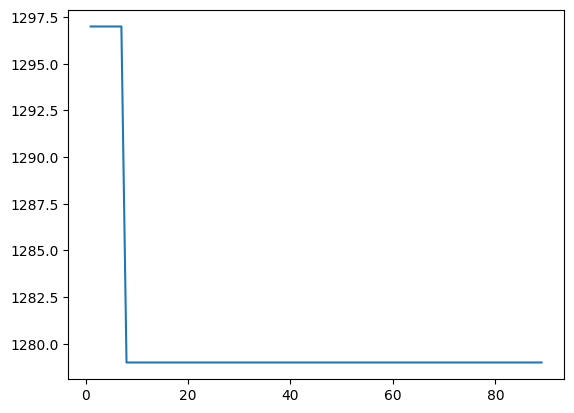

In [85]:
tai_inst = load_tai(20, 5)
hh = SAGA(tai_inst[0],  variety_degree= 5)
hps_trace, current_make_span_trace, loc_make_spane_star_trace, temp_trace = hh.optim(T_min=0.0001, trace=True)
print('make_span_star', hh.make_span_star)
plt.plot(range(1, len(current_make_span_trace)+1), current_make_span_trace)

20 jobs 5 machines

In [6]:
instances_20_5 = load_tai(20,5)
makes_spans_20_5 = []
for instance in instances_20_5:
    saga = SAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_20_5.append(saga.make_span_star)

Temperature 0.47829690000000014:   1%|▏         | 7/500 [00:33<20:30,  2.50s/it]

20 jobs 10 machines

In [ ]:
instances_20_10 = load_tai(20,10)
makes_spans_20_10 = []
for instance in instances_20_10:
    saga = SAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_20_10.append(saga.make_span_star)

20 jobs 20 machines

In [ ]:
instances_20_20 = load_tai(20,20)
makes_spans_20_20 = []
for instance in instances_20_20:
    saga = SAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_20_20.append(saga.make_span_star)

50 jobs 5 machines

In [ ]:
instances_50_5 = load_tai(50,5)
makes_spans_50_5 = []
for instance in instances_50_5:
    saga = SAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_50_5.append(saga.make_span_star)

50 jobs 10 machines

In [ ]:
instances_50_10 = load_tai(50,10)
makes_spans_50_10 = []
for instance in instances_50_10:
    saga = SAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_50_10.append(saga.make_span_star)

50 jobs 20 machines

In [ ]:
instances_50_20 = load_tai(50,20)
makes_spans_50_20 = []
for instance in instances_50_20:
    saga = SAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_50_20.append(saga.make_span_star)

100 jobs 5 machines

In [ ]:
instances_100_5 = load_tai(100,5)
makes_spans_100_5 = []
for instance in instances_100_5:
    saga = SAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_100_5.append(saga.make_span_star)

100 jobs 10 machines

In [ ]:
instances_100_10 = load_tai(100,10)
makes_spans_100_10 = []
for instance in instances_100_10:
    saga = SAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_100_10.append(saga.make_span_star)

200 jobs 10 machines

In [ ]:
instances_200_10 = load_tai(200,10)
makes_spans_200_10 = []
for instance in instances_200_10:
    saga = SAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_200_10.append(saga.make_span_star)

200 jobs 20 machines

In [ ]:
instances_20_20 = load_tai(200,20)
makes_spans_20_20 = []
for instance in instances_20_20:
    saga = SAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_20_20.append(saga.make_span_star)

500 jobs 20 machines

In [ ]:
instances_500_20 = load_tai(500,20)
makes_spans_500_20 = []
for instance in instances_500_20:
    saga = SAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_500_20.append(saga.make_span_star)